<a href="https://colab.research.google.com/github/liuxx479/Outlier/blob/master/notebooks/ResNet_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function, division, absolute_import

import numpy.random as npr
import os

import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import jax.numpy as np
from jax.config import config
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
import tensorflow as tf
from jax.experimental.stax import (AvgPool, BatchNorm, Conv, Dense, FanInSum,
                                   FanOut, Flatten, GeneralConv, Identity,
                                   MaxPool, Relu, LogSoftmax)


%tensorflow_version 2.x
%pylab inline
import tensorflow_datasets as tfds

!pip install --quiet git+https://github.com/liuxx479/Outlier.git
from outlier.datasets import gaussian_convergence


########### JL note: mostly following https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/neural_network_with_tfds_data.ipynb
########### https://github.com/google/jax/blob/master/examples/resnet50.py

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['np', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
######### mount google drive file
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/My Drive'
data_path = os.path.join(root,'tensorflow_datasets/')
model_path= os.path.join(root,'models/')

if not os.path.isdir(model_path):
    os.makedirs(model_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
########## load data from gdrive, if need to downlaod again, set download=1
VERSION = tfds.core.Version('0.1.0')
dataset, info = tfds.load(name="gaussian_convergence", download=0, split="train", data_dir=data_path, with_info=True)

In [4]:
print ('data size:',info.splits['train'].num_examples)
data_size=info.splits['train'].num_examples

data size: 20000


In [0]:
# for example in dataset.take(1):  #take 1 for test
#   kappa_map, params = example["map"], example["params"]
#   imshow(kappa_map)
#   print(params)

In [0]:
S8_gen= lambda params: np.sqrt(params.T[0]/0.3)*params.T[1]

In [0]:
############ JL: resnet architecture, mostly unchanged, other than removed bunch of idensity matrices

def ConvBlock(kernel_size, filters, strides=(2, 2)):
  ks = kernel_size
  filters1, filters2, filters3 = filters
  Main = stax.serial(
      Conv(filters1, (1, 1), strides), BatchNorm(), Relu,
      Conv(filters2, (ks, ks), padding='SAME'), BatchNorm(), Relu,
      Conv(filters3, (1, 1)), BatchNorm())
  Shortcut = stax.serial(Conv(filters3, (1, 1), strides), BatchNorm())
  return stax.serial(FanOut(2), stax.parallel(Main, Shortcut), FanInSum, Relu)

def IdentityBlock(kernel_size, filters):
  ks = kernel_size
  filters1, filters2 = filters
  def make_main(input_shape):
    # the number of output channels depends on the number of input channels
    return stax.serial(
        Conv(filters1, (1, 1)), BatchNorm(), Relu,
        Conv(filters2, (ks, ks), padding='SAME'), BatchNorm(), Relu,
        Conv(input_shape[3], (1, 1)), BatchNorm())
  Main = stax.shape_dependent(make_main)
  return stax.serial(FanOut(2), stax.parallel(Main, Identity), FanInSum, Relu)

# ResNet architectures compose layers and ResNet blocks
def ResNet50(num_classes):
  ########## JL to do: maybe remove some IdentityBlocks..
  return stax.serial(
      GeneralConv(('HWCN', 'OIHW', 'NHWC'), 64, (7, 7), (2, 2), 'SAME'),
      BatchNorm(), 
      Relu, 
      MaxPool((3, 3), strides=(2, 2)),
      ConvBlock(3, [64, 64, 256], strides=(1, 1)),
      IdentityBlock(3, [64, 64]),
      IdentityBlock(3, [64, 64]),
      # ConvBlock(3, [128, 128, 512]),
      # IdentityBlock(3, [128, 128]),
      # IdentityBlock(3, [128, 128]),
      # IdentityBlock(3, [128, 128]),
      ConvBlock(3, [256, 256, 1024]),
      IdentityBlock(3, [256, 256]),
      # IdentityBlock(3, [256, 256]),
      # IdentityBlock(3, [256, 256]),
      # IdentityBlock(3, [256, 256]),
      # IdentityBlock(3, [256, 256]),
      ConvBlock(3, [512, 512, 2048]),
      # IdentityBlock(3, [512, 512]),
      IdentityBlock(3, [512, 512]),
      AvgPool((7, 7)), 
      Flatten, 
      Dense(num_classes))

In [0]:
from jax import random
rng_key = random.PRNGKey(0)

In [0]:
def loss(params, batch):
  kappa_map, params_true = batch
  params_pred = predict_fun(params, kappa_map)
  #out1 = np.sum((S8_gen(params_pred) - S8_gen(params_true))**2) ## controls S8
  # out2 = np.sum((params_pred - params_true)**2) ## controls individual params
  out2 = np.mean((params_pred - params_true)**2)
  return out2

In [0]:
########### hack from: https://github.com/google/jax/issues/2116
from jax.tree_util import pytree
import pickle
from pathlib import Path
from typing import Union

suffix = '.pickle'

def savemodel(data: pytree, path: Union[str, Path], overwrite: bool = False):
    path = Path(path)
    if path.suffix != suffix:
        path = path.with_suffix(suffix)
    path.parent.mkdir(parents=True, exist_ok=True)
    if path.exists():
        if overwrite:
            path.unlink()
        else:
            raise RuntimeError(f'File {path} already exists.')
    with open(path, 'wb') as file:
        pickle.dump(data, file)


def loadmodel(path: Union[str, Path]) -> pytree:
    path = Path(path)
    if not path.is_file():
        raise ValueError(f'Not a file: {path}')
    if path.suffix != suffix:
        raise ValueError(f'Not a {suffix} file: {path}')
    with open(path, 'rb') as file:
        data = pickle.load(file)
    return data

In [0]:
####### prepare training sets

batch_size = 64 ### number of maps per batch
valid_size = 128 #int(0.1*data_size)
test_size = int(0.1*data_size)
train_size = data_size - valid_size -test_size #int(0.8*data_size)

dataset.shuffle(1000)
valid_batch = dataset.take(valid_size).batch(valid_size)
test_batch = dataset.skip(valid_size).take(test_size).batch(test_size)
train_batch = dataset.skip(valid_size+test_size).repeat().batch(batch_size)

def preprocess(dataset, augment=1):
  images=dataset['map']
  images=tf.transpose(images, (1,2,0)) ##### move the batch size to last axis
  # print ('preproess shape', images.numpy().shape)
  if augment:
    images=tf.image.random_flip_left_right(images)
    images=tf.image.random_flip_up_down(images)
    images=tf.image.rot90(images, k=randint(4)) #### rotate an image in a random angle
  images=tf.expand_dims(images,-2) ## expand the dimension to include channel
  # images=tf.transpose(images, (1,2,3,0))
  # print ('post processing shape',images.numpy().shape)
  return images.numpy(), dataset['params'].numpy()

for itest in valid_batch:
  valid_batch = preprocess(itest, augment=0)
  valid_maps, params_valid = valid_batch
for itest in test_batch:
  test_batch = preprocess(itest, augment=0)
  test_maps, params_test = test_batch

In [0]:
############ JL: batch generator
def synth_batches():
  for ibatch in train_batch:
    yield preprocess(ibatch)

batches = synth_batches()

In [43]:
print (test_maps.shape, params_test.shape)
print (valid_maps.shape, params_valid.shape)
itrain_batch  = next(batches)
print (itrain_batch[0].shape, itrain_batch[1].shape)

(256, 256, 1, 2000) (2000, 2)
(256, 256, 1, 128) (128, 2)
(256, 256, 1, 64) (64, 2)


In [44]:
############# JL: training

num_classes = 2
input_shape = (256, 256, 1, batch_size)
num_steps = int(train_size/batch_size) ## number of steps per epoch
num_epochs = 50
step_size = 0.001
epoch0=23

init_fun, predict_fun = ResNet50(num_classes)
# _, init_params = init_fun(rng_key, input_shape)
######### JL to do: change to grab the newest file automatically
fn_model=model_path+'jax_resnet_model_epoch{:0.0f}_stepsize{}.pickle'.format(epoch0, step_size/10)
init_params = loadmodel(fn_model)

opt_init, opt_update, get_params = optimizers.adam(step_size) ##### seems to work best
# opt_init, opt_update, get_params = optimizers.adagrad(step_size) #### seems to work
# opt_init, opt_update, get_params = optimizers.sgd(step_size) ### doesn't work well
# opt_init, opt_update, get_params = optimizers.nesterov(step_size, mass=0.9) ### doesn't work well
# opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=0.9) ## doesn't work well

@jit
def update(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, grad(loss)(params, batch), opt_state)

opt_state = opt_init(init_params)

start_time = time.time()
for epoch in range(num_epochs):
  for istep in range(num_steps):  
    this_batch=next(batches)
    opt_state = update(istep, opt_state, this_batch)
    if istep%50==0:
      epoch_time = (time.time() - start_time)/60.0 ## minutes
      test_NNparams = get_params(opt_state)
      train_loss = loss(test_NNparams, this_batch)
      valid_loss = loss(test_NNparams, valid_batch)
      print("Epoch {} at {:0.2f}m, train loss: {:0.4f}, validation loss: {:0.4f}".format(epoch+epoch0, 
                                                   epoch_time, train_loss, valid_loss))
  fn_model=model_path+'jax_resnet_model_epoch{:0.0f}_stepsize{}.pickle'.format(epoch+epoch0, step_size)
  savemodel(test_NNparams, fn_model,overwrite=1)

Epoch 23 at 0.26m, train loss: 2777.79, validation loss: 2696.29
Epoch 23 at 0.63m, train loss: 0.50, validation loss: 0.49
Epoch 23 at 1.01m, train loss: 0.09, validation loss: 0.10
Epoch 23 at 1.38m, train loss: 0.05, validation loss: 0.07
Epoch 23 at 1.76m, train loss: 0.06, validation loss: 0.06
Epoch 23 at 2.13m, train loss: 0.06, validation loss: 0.05
Epoch 24 at 2.38m, train loss: 0.05, validation loss: 0.04
Epoch 24 at 2.75m, train loss: 0.05, validation loss: 0.04
Epoch 24 at 3.12m, train loss: 0.03, validation loss: 0.03
Epoch 24 at 3.50m, train loss: 0.05, validation loss: 0.04
Epoch 24 at 3.87m, train loss: 0.03, validation loss: 0.03
Epoch 24 at 4.24m, train loss: 0.03, validation loss: 0.03
Epoch 25 at 4.49m, train loss: 0.04, validation loss: 0.03
Epoch 25 at 4.87m, train loss: 0.03, validation loss: 0.03
Epoch 25 at 5.24m, train loss: 0.03, validation loss: 0.03
Epoch 25 at 5.61m, train loss: 0.03, validation loss: 0.02
Epoch 25 at 5.98m, train loss: 0.02, validation lo

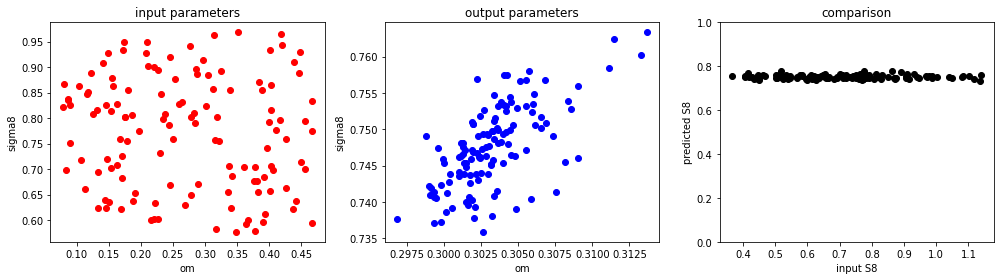

In [45]:
test_NNparams = loadmodel(fn_model)

params_pred = predict_fun(test_NNparams, valid_maps)
params_input = params_valid
true_s8=S8_gen(params_valid)
pred_s8=S8_gen(params_pred)

figure(figsize=(14,4))
subplot(1,3,1)
scatter(params_input.T[0], params_input.T[1],color='r')
title('input parameters')
xlabel('om')
ylabel('sigma8')
subplot(1,3,2)
scatter(params_pred.T[0], params_pred.T[1],color='b')
title('output parameters')
xlabel('om')
ylabel('sigma8')
subplot(1,3,3)
scatter(true_s8, pred_s8, color='k')
xlabel('input S8')
ylabel('predicted S8')
ylim(0,1)
title('comparison')
plt.tight_layout()

In [0]:
############ check  parameter shape
# j=0
# for iparam in trained_params:
#   print ('layer:',j, '/ parameter shape:', array(iparam).shape)
#   #print (iparam)
#   j+=1

In [0]:
############# test data save and restart - pass
# step_size=0.01
# opt_init, opt_update, get_params = optimizers.adam(step_size) ##### seems to work best

# _, init_params = init_fun(rng_key, input_shape)
# savemodel(init_params, model_path+'test2')
# testmodel = loadmodel(model_path+'test2.pickle')
# opt_init(testmodel)

In [0]:
########## test file save -- pass ############
## saved as npy, and can be loaded and use as model prediction directly
# np.save(model_path+'test', test_params)
# test_model = np.load(model_path+'test.npy',allow_pickle=1)
# loss(test_model, this_batch)

In [0]:
########### test generator output shape - pass
# final_NNparams = get_params(opt_state)
# np.save(model_path+'resnet_params_{:.0f}epochs_{:.2f}stepsize.npy'.format(epoch+1, step_size), final_NNparams)

# predictions = predict_fun(final_NNparams, kappa_map)